# Time Series Analysis of Seattle Public Library Checkouts

#### Data Source:
https://data.seattle.gov/dataset/Checkouts-by-Title-Physical-Items-/3h5r-qv5w<br>https://www.kaggle.com/seattle-public-library/seattle-library-checkout-records
* Investigating daily, weekly, monthly charts
* Statistical approach - Autoregression, Holt Winters
* Time Series prediction using Facebook Prophet
* Machine Learning models for predicting daily checkouts
* Error analysis

### Problem Statement: make a prediction for future checkouts. 

As a proof of concept, we'll explore different approaches to making predictions for checkouts. Knowing the volume of checkouts at a branch could help with staffing decisions. A forecast showing a clear spike in checkouts could suggest having more workers available on those days. We'll be looking at the case of an entire library system since that's the granularity of the data available. These predictions could be improved on the individual branch level. More globally, analyzing the time series and seeing trends downward might spark questions about why usage is down, where users are going, and what can be done to increase usage again.

In [168]:
# import libraries
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from datetime import date
import holidays
import seaborn as sns
import pickle
from pylab import rcParams
from fbprophet import Prophet
%matplotlib inline

# statsmodels packages
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# sklearn :: utils
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# sklearn :: models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# sklearn :: evaluation metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# apply style to all the charts
sns.set_style('whitegrid')

# convert scientific notation to decimals
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Load checkout records for 2016-2018

In [169]:
# create 3 year timeseries

#df_full = pd.DataFrame()

#for i in range(2016,2019):
#    df = pd.read_csv('../../data/raw/Checkouts_By_Title_Data_Lens' + str(i) + '.csv', usecols=['CheckoutDateTime', 'BibNumber'])
#    df['CheckoutDateTime'] = pd.to_datetime(df['CheckoutDateTime'], format= '%m/%d/%Y %I:%M:%S %p')
#    df.set_index('CheckoutDateTime', inplace=True)
#    df = df.resample('D').count()
#    df.columns = ['checkouts']
#    df_full = pd.concat([df_full, df])

In [170]:
# for saving the daily timeseries

#df_full['datetime'] = df_full.index
#df_full.reset_index(drop=True, inplace=True)
#df_full = df_full[['datetime', 'checkouts']]
#df_full.to_csv('../../data/processed/checkout_counts_16to18.csv', index=False)

In [171]:
# loading the new three year timeseries

df = pd.read_csv('../../data/processed/checkout_counts_16to18.csv')
df['datetime'] = pd.to_datetime(df['datetime'], format= '%Y-%m-%d')
df.set_index('datetime', inplace=True)
df = df.resample('D').sum()

### Look at daily, weekly, monthly checkouts
We have already looked at the monthly and weekly charts in the EDA but here we can observe it over a period of three years instead of just one. A new addition is the daily chart which shows the weekly pattern quite clearly. Most noticeably, the periodic huge dips to 0 checkouts are revealed to be holidays when every branch in the system is closed. Some large surges in checkouts seem anomalous like in June 2017, and a few days in September of every year. We'll take a look at potential causes for this.

In [15]:
# create weekly dataframe
df_weekly = df.resample('W').sum()
df_weekly.columns = ['checkouts']

In [16]:
# create monthly dataframe
df_monthly = df.resample('M').sum()
df_monthly.columns = ['checkouts']

### Biggest checkout days

The three biggest checkout days occur in June 2017. It's really clear from the chart that something is happening. Researching the events calendar for the SPL, it is possible that the beginning of the Summer Learning program might have attracted kids and their parents to checkout more books than usual in the buildup to the start of the program on June 15. June 5, however seems to be largely unaccounted for except for a visit from author Heather Gudenkauf at the central branch. It doesn't seem to be enough to create such a huge spike for one day.

In [172]:
# Biggest checkout days
df['checkouts'].sort_values(ascending=False).head()

datetime
2017-06-05    36500
2017-06-13    36429
2017-06-14    33220
2016-09-06    28825
2016-02-16    27914
Name: checkouts, dtype: int64

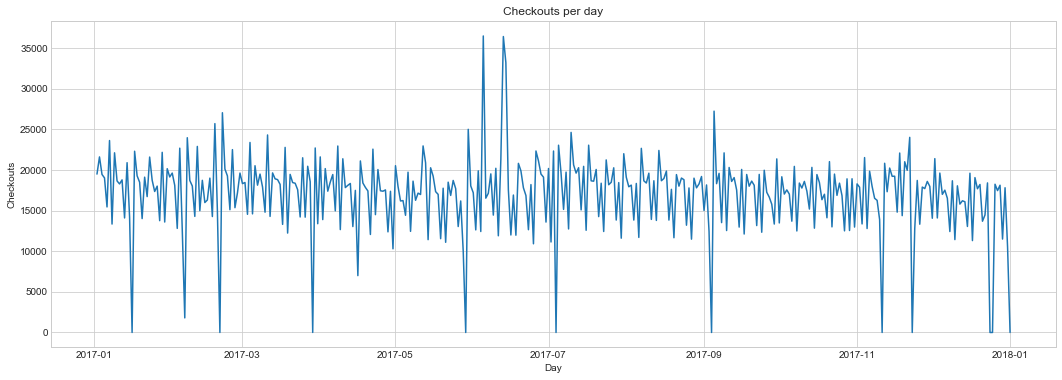

In [17]:
# plot daily chart for just 2017
plt.figure(figsize=(18,6))
plt.plot(df['2017-01-02':'2018-01-01'])
plt.title('Checkouts per day')
plt.xlabel('Day')
plt.ylabel('Checkouts')
plt.show()

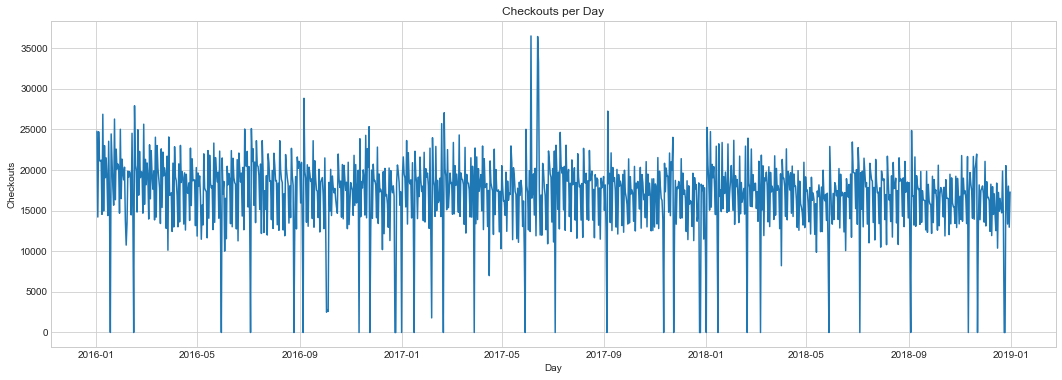

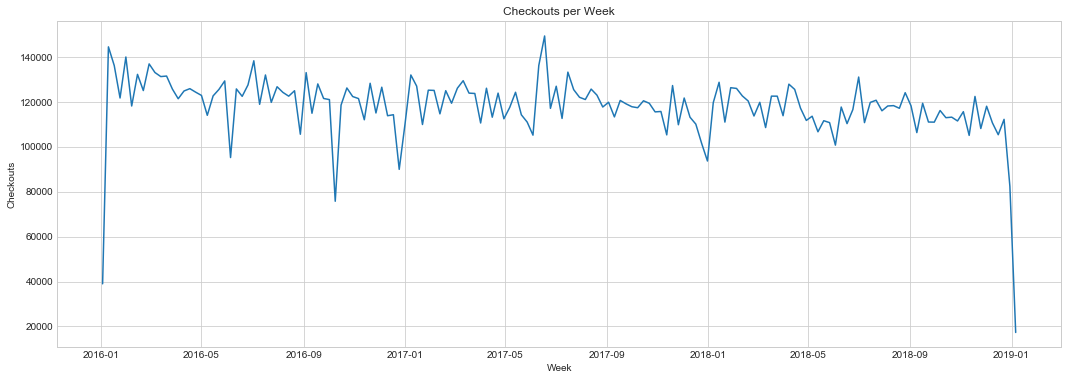

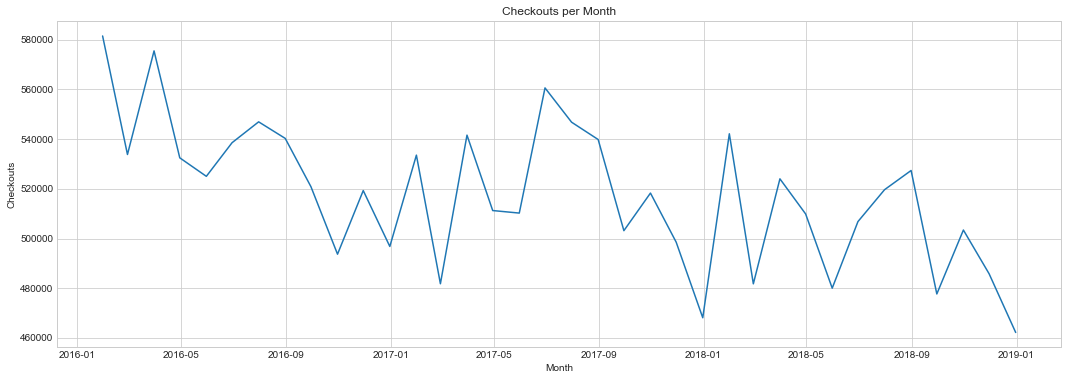

In [18]:
# plot daily, weekly, and monthly checkouts
charts = [df, df_weekly, df_monthly]
titles = ['Day','Week','Month']

for i in range(0,3):
    plt.figure(figsize=(18,6))
    plt.plot(charts[i])
    plt.title('Checkouts per ' + titles[i])
    plt.xlabel(titles[i])
    plt.ylabel('Checkouts')
    plt.show()

# Autocorrelation
Using lags, we can see how the checkout counts for days are related to each other. Once again, the weekly pattern is mimicked as we see the cycle restarting every 7 days.

<Figure size 864x432 with 0 Axes>

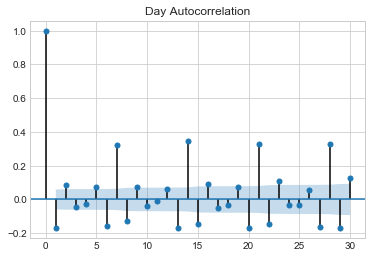

<Figure size 864x432 with 0 Axes>

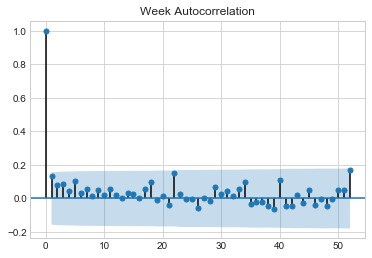

<Figure size 864x432 with 0 Axes>

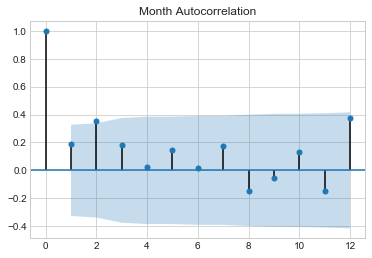

In [19]:
lags = [30, 52, 12]
titles = ['Day','Week','Month']

for i in range(0,3):
    plt.figure(figsize=(12,6))
    plot_acf(charts[i], lags=lags[i])
    plt.title(titles[i] + ' Autocorrelation')
        

## Differencing
With differencing we can see the biggest swings in checkouts per day. The holiday closures are quite obvious. For instance, on MLK Jr. day in 2016, the difference between the day before and the day it was closed was -15,923. The day after the holiday, there was an increase of 24,433 since 0 books were checked out the day before. The biggest positive difference was after labour day in 2016. The biggest negative difference was for thanksgiving in 2016. Perhaps people check out more books right before the extra long Thanksgiving weekend, when many people travel and have some downtime.

For a predictive model, these outliers could cause trouble.

In [22]:
df.diff()[15:20]

,checkouts
datetime,
2016-01-17,-7612.00
2016-01-18,-15923.00
2016-01-19,24433.00
2016-01-20,-3311.00
2016-01-21,-3210.00


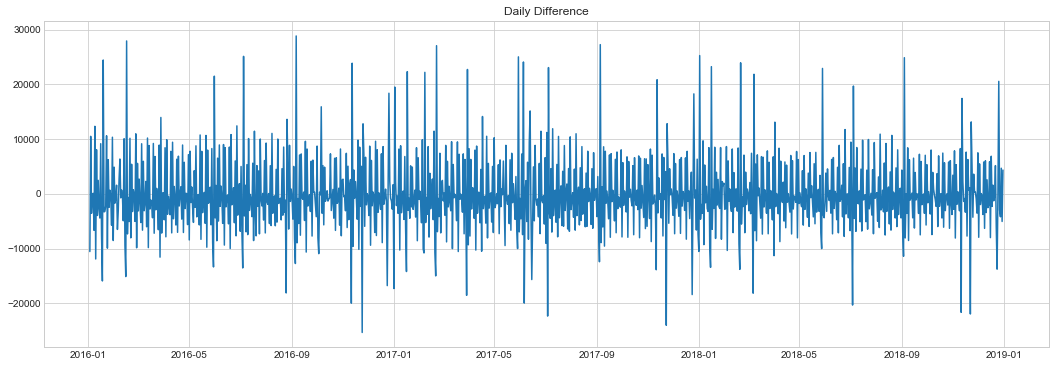

In [13]:
# plot the daily diff
plt.figure(figsize=(18,6))
plt.plot(df.diff())
plt.title('Daily Difference')
plt.show()

In [38]:
# What is the day with the highest positive difference?
print('positive difference\n', df.diff()[df.diff()['checkouts'] == [df.diff()['checkouts'].max()]])
# What is the day with the highest negative difference?
print('\nnegative difference\n', df.diff()[df.diff()['checkouts'] == [df.diff()['checkouts'].min()]])

positive difference
             checkouts
datetime             
2016-09-06   28825.00

negative difference
             checkouts
datetime             
2016-11-24  -25335.00


In [40]:
# days with the biggest differences probably due to holidays and closures
df.diff()[(df.diff()['checkouts'] < -12000) | (df.diff()['checkouts'] > 15000)]

,checkouts
datetime,
2016-01-18,-15923.00
2016-01-19,24433.00
2016-02-15,-15124.00
2016-02-16,27914.00
2016-05-30,-13362.00
2016-05-31,21483.00
2016-07-04,-13550.00
2016-07-05,25100.00
2016-08-25,-18118.00


In [32]:
len(df.diff()[(df.diff()['checkouts'] < -12000) | (df.diff()['checkouts'] > 15000)])

56

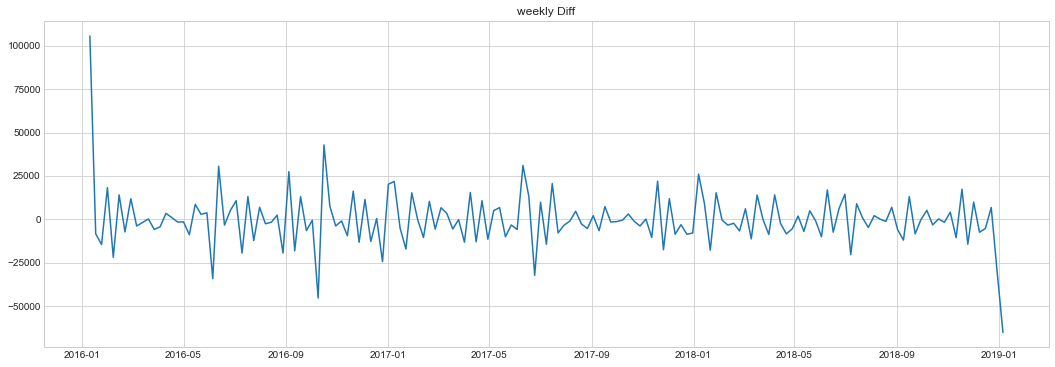

In [18]:
# plot the weekly diff
plt.figure(figsize=(18,6))
plt.plot(df_weekly.diff())
plt.title('weekly Diff')
plt.show()

In [19]:
# What is the week with the highest positive difference?
df_weekly['2016-01-11':'2018-12-26'].diff()[df_weekly['2016-01-11':'2018-12-26'].diff()['checkouts'] == [df_weekly['2016-01-11':'2018-12-26'].diff()['checkouts'].max()]]

,checkouts
datetime,
2016-10-16,42836.00


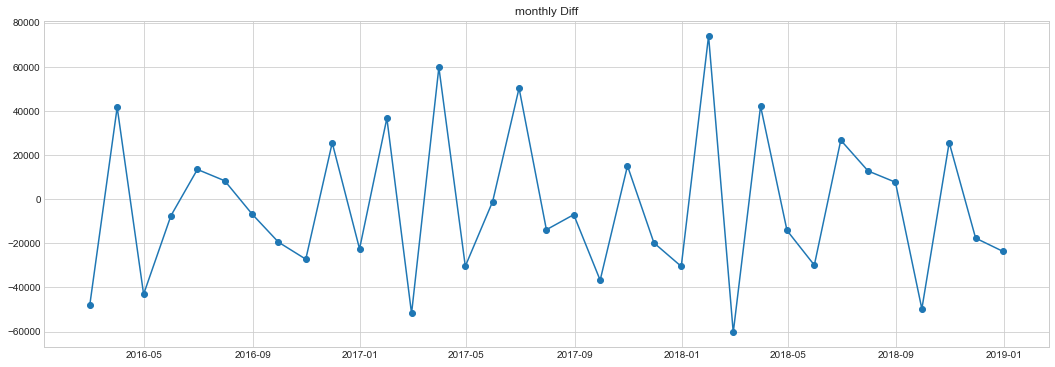

In [20]:
# plot the monthly diff
plt.figure(figsize=(18,6))
plt.plot(df_monthly.diff(), '-o')
plt.title('monthly Diff')
plt.show()

## Time Series Decomposition
From the decomposition charts, using an additive model, we can see the weekly trend is slowly declining. People are checking out fewer physical books every year. However, this does not account for the increase in e-book checkouts. A further exploration would investigate how many of the users are replacing their physical items with e-books.

The residual plot for the daily dataframe shows how much noise the holiday closures create.

#### Weekly decomposition

[16.0, 10.0]


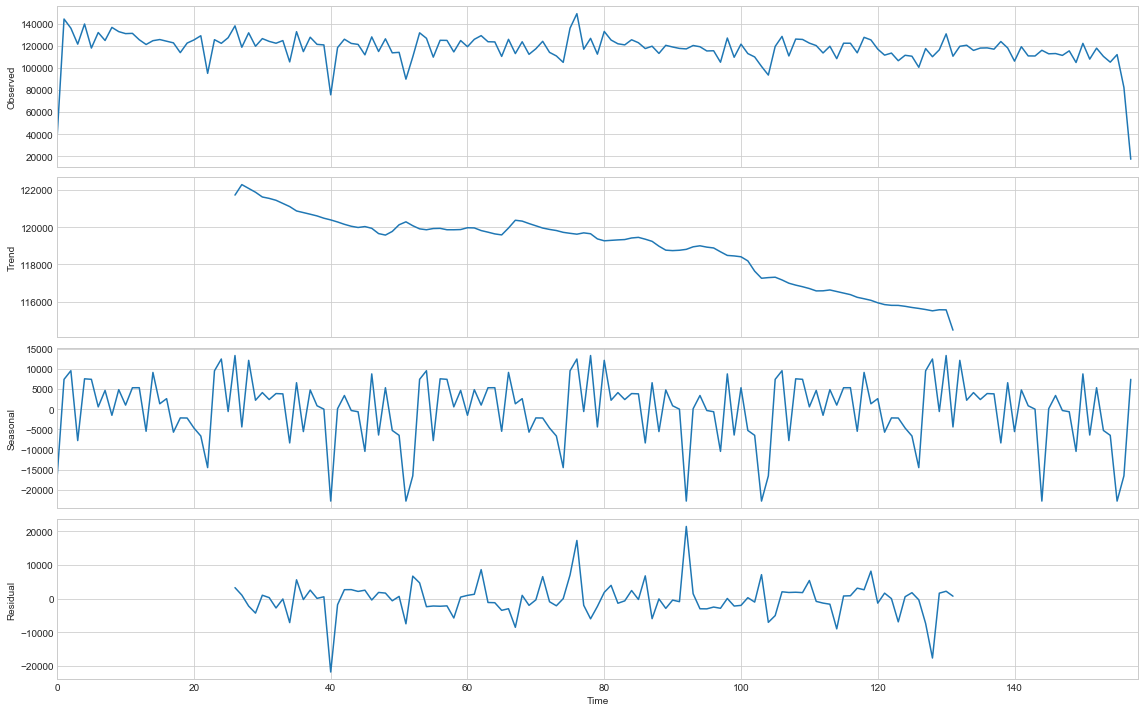

In [45]:
rcParams['figure.figsize'] = 16, 10
series = df_weekly['checkouts'].dropna().values
result = seasonal_decompose(series, model='additive', freq=52)
result.plot()
plt.show()

#### Daily decomposition with weekly frequency

[16.0, 10.0]


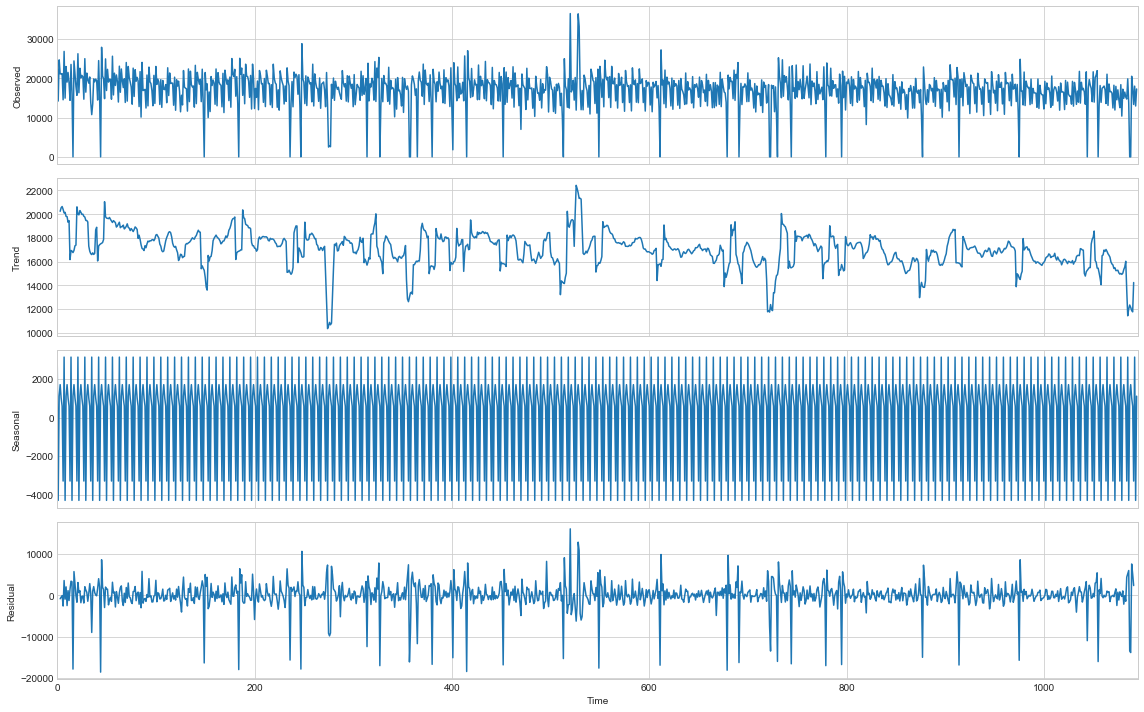

In [47]:
rcParams['figure.figsize'] = 16, 10
series = df['checkouts'].dropna().values
result = seasonal_decompose(series, model='additive', freq=7)
result.plot()
plt.show()

In [52]:
# see the decomposition in a dataframe
df['dow'] = df.index.dayofweek
df['trend'] = result.trend
df['seasonal'] = result.seasonal
df['resid'] = result.resid
df_decomp = df[['trend', 'seasonal', 'resid']]
df.head()

,checkouts,dow,trend,seasonal,resid
datetime,,,,,
2016-01-02,24763,5,nan,3141.11,nan
2016-01-03,14212,6,nan,-4292.50,nan
2016-01-04,24704,0,nan,1113.74,nan
2016-01-05,21140,1,20243.43,1710.85,-814.28
2016-01-06,21135,2,20543.14,1016.71,-424.85


## Smoothing

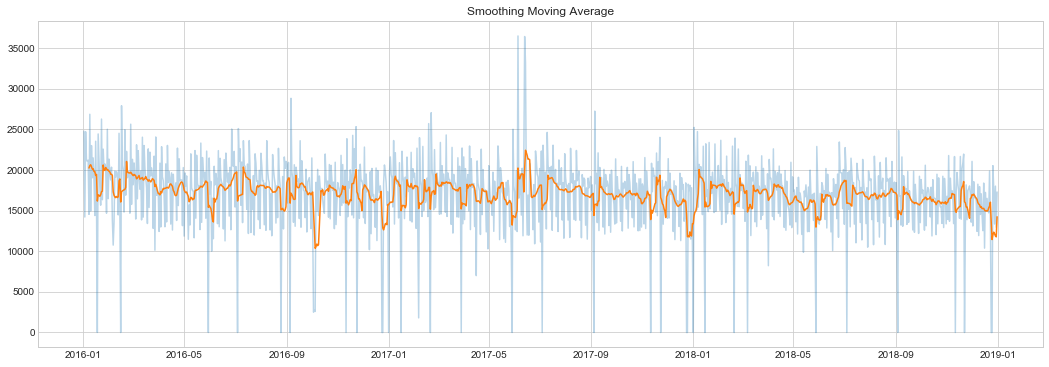

In [25]:
# rolling - moving average
plt.figure(figsize=(18,6))
plt.title('Smoothing Moving Average')
plt.plot(df['checkouts'], alpha=0.3)
plt.plot(df['checkouts'].rolling(window=7).mean())
plt.show()

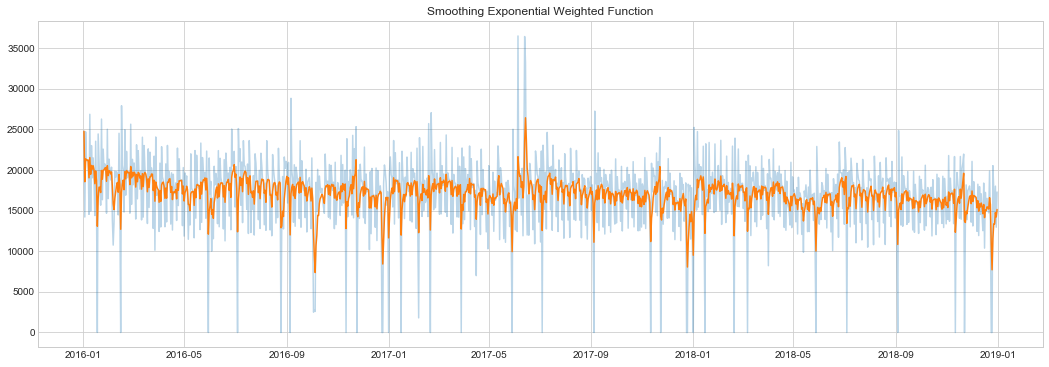

In [26]:
# exponential weighted functions
plt.figure(figsize=(18,6))
plt.title('Smoothing Exponential Weighted Function')
plt.plot(df['checkouts'], alpha=0.3)
plt.plot(df['checkouts'].ewm(alpha=0.3).mean())
plt.show()

## Simple anomaly detection

Using the residuals from the decomposition, we can plot the noise in the time series. Most of it here is caused by the factors we've already noticed.

resid_mean:  -0.2933981533050281
resid_std:  3572.3487865146726


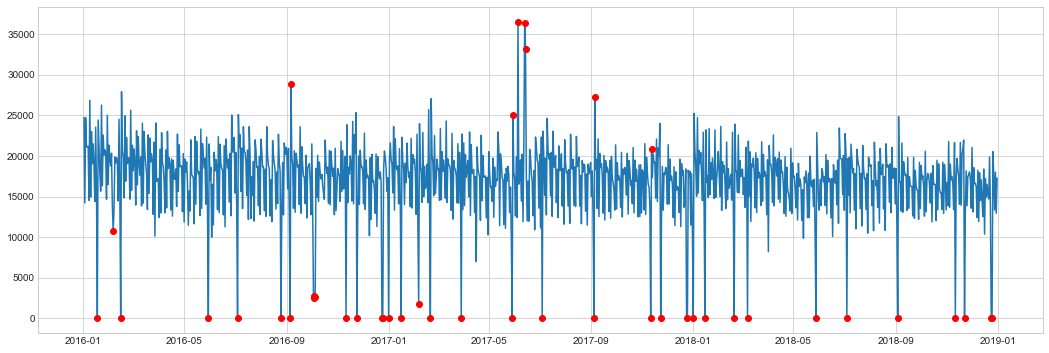

In [54]:
resid_mean = df['resid'].dropna().mean()
resid_std = df['resid'].dropna().std()
print('resid_mean: ', resid_mean)
print('resid_std: ', resid_std)

n_std = 2.5
df_anomaly = df[(df['resid'] < resid_mean - n_std * resid_std)|(df['resid'] > resid_mean + n_std * resid_std)]

# plot checkouts, plot anomoly on same chart
# k is index date on x-axis, v['checkouts'] is value of k row, checkouts column on y axis
plt.figure(figsize=(18,6))
plt.plot(df['checkouts'])
for k, v in df_anomaly.iterrows():
    plt.plot(k, v['checkouts'], 'or')
plt.show()

In [55]:
df_anomaly.head()

,checkouts,dow,trend,seasonal,resid
datetime,,,,,
2016-01-18,4,0,16763.29,1113.74,-17873.02
2016-02-06,10756,5,16599.43,3141.11,-8984.54
2016-02-15,0,0,17500.57,1113.74,-18614.31
2016-05-30,0,0,15273.29,1113.74,-16387.02
2016-07-04,0,0,16883.43,1113.74,-17997.17


## Statistical approach
### Autoregressive

The autoregression model uses lagged variables as input variables. It automatically chooses an appropriate lag. It doesn't do a terrible job predicting the future periods because it sticks to the weekly pattern that we've observed. Most checkouts on Saturday, and least on Friday and Saturday. It has not accounted for the closure on Jan 1 or the spike that is typically seen in the first week of January.

datetime
2018-12-25        0
2018-12-26    20534
2018-12-27    17551
2018-12-28    13348
2018-12-29    18014
2018-12-30    12960
2018-12-31    17292
Freq: D, Name: checkouts, dtype: int64
2019-01-01   12860.02
2019-01-02   17714.34
2019-01-03   16793.59
2019-01-04   14945.01
2019-01-05   18481.26
2019-01-06   15202.04
2019-01-07   15048.60
2019-01-08   12440.04
2019-01-09   18040.40
2019-01-10   16668.23
2019-01-11   16147.26
2019-01-12   18475.67
2019-01-13   15363.86
2019-01-14   15248.26
2019-01-15   12566.97
Freq: D, dtype: float64


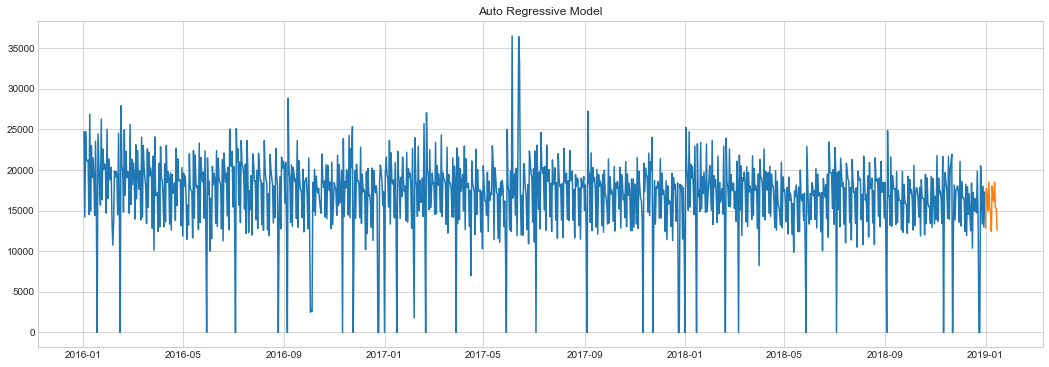

In [32]:
# Autoregressive Model
model = AR(df['checkouts'])
# fit model
model_fit = model.fit()
print(df['checkouts'].tail(7))
# calculate prediction
yhat = model_fit.predict(len(df['checkouts']), len(df['checkouts'])+14)
print(yhat)
# plot results
plt.figure(figsize=(18,6))
plt.title('Auto Regressive Model')
plt.plot(df['checkouts'])
plt.plot(yhat)
plt.show()

## Holt Winters - exponential smoothing

Holt Winters does a better job noticing the increases in January checkouts and the dips due to closure but it cannot accurately capture the "anomalous" dips from the holiday.

2019-01-01    9582.86
2019-01-02   22382.19
2019-01-03   19298.71
2019-01-04   16079.85
2019-01-05   21043.61
2019-01-06   15124.54
2019-01-07    9702.97
2019-01-08   10788.50
2019-01-09   23587.83
2019-01-10   20504.35
2019-01-11   17285.50
2019-01-12   22249.25
2019-01-13   16330.19
2019-01-14   10908.62
2019-01-15   11994.15
Freq: D, dtype: float64


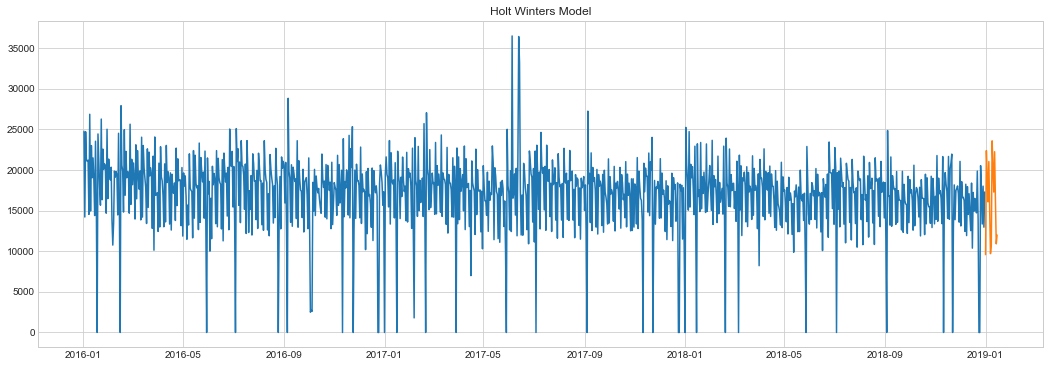

In [36]:
# Holt Winters 
# fit model
model = ExponentialSmoothing(df['checkouts'], trend='add', seasonal='add', seasonal_periods=7)
model_fit = model.fit(smoothing_level=0.2, smoothing_slope=0.1, smoothing_seasonal=0.5)
# calculate prediction
yhat = model_fit.predict(len(df['checkouts']), len(df['checkouts'])+14)
print(yhat)
plt.figure(figsize=(18,6))
plt.title('Holt Winters Model')
plt.plot(df['checkouts'])
plt.plot(yhat)
plt.show()

## Facebook Prophet Time Series

The Facebook Prophet prediction produces similar results to the Holt winters since the increase in January is accounted for and it follows the basic day of the week trend. A further exploration would include the holiday feature of the Prophet package which could help with all the closure outliers. Prophet does do a great job of capturing the 3 year trend as seen in the plots of the components. There is a clear downward trend for checkouts.

In [66]:
df_proph = pd.read_csv('../../data/processed/checkout_counts_16to18.csv')
df_proph['datetime'] = pd.to_datetime(df_proph['datetime'], format= '%Y-%m-%d')
df_proph.columns = ['ds','y']

In [67]:
df_proph.head()

,ds,y
0,2016-01-02,24763
1,2016-01-03,14212
2,2016-01-04,24704
3,2016-01-05,21140
4,2016-01-06,21135


In [68]:
m = Prophet()
m.fit(df_proph)
future = m.make_future_dataframe(periods=30)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [69]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

,ds,yhat,yhat_lower,yhat_upper
1093,2019-01-01,17324.97,12894.83,22193.15
1094,2019-01-02,16830.24,11898.20,21830.44
1095,2019-01-03,16616.84,11933.61,20992.37
1096,2019-01-04,12922.07,8037.14,17609.63
1097,2019-01-05,19557.53,14999.74,24603.75
1098,2019-01-06,12381.13,7656.77,17043.22
1099,2019-01-07,18010.92,13242.41,22998.33
1100,2019-01-08,18626.17,13744.54,23245.89
1101,2019-01-09,18065.25,13264.45,22772.68
1102,2019-01-10,17767.70,12719.53,22573.96


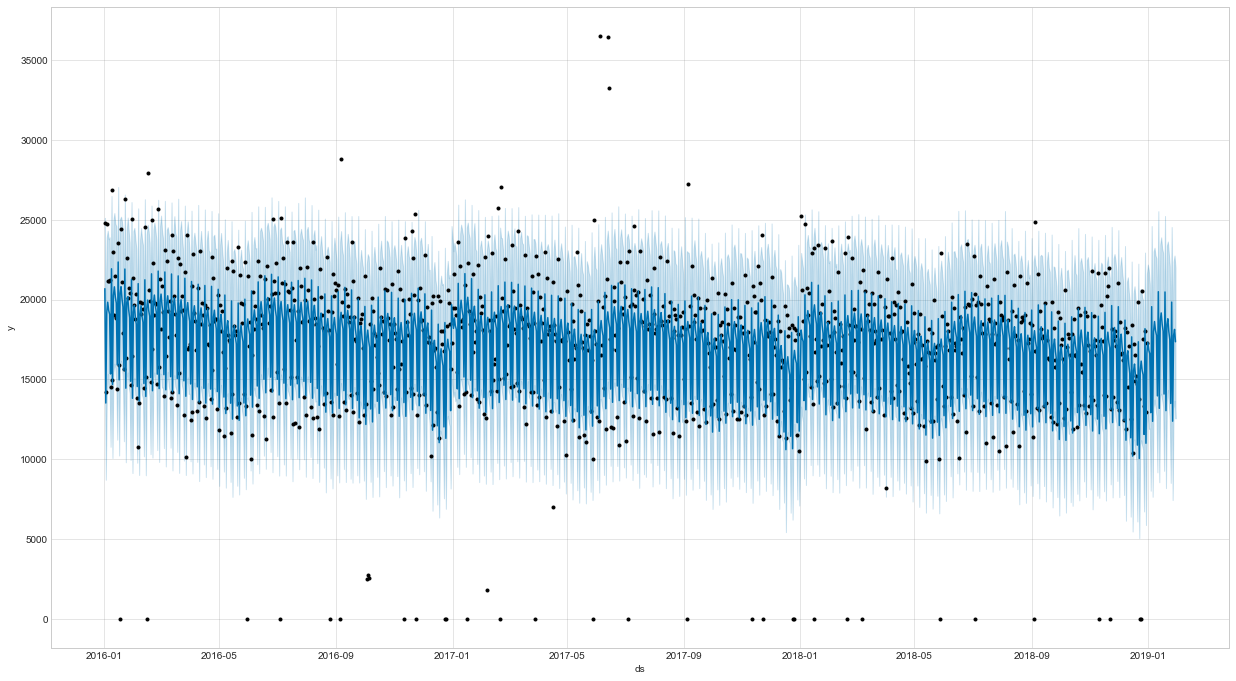

In [72]:
fig1 = m.plot(forecast)
fig1.set_size_inches(18, 10)
plt.show()

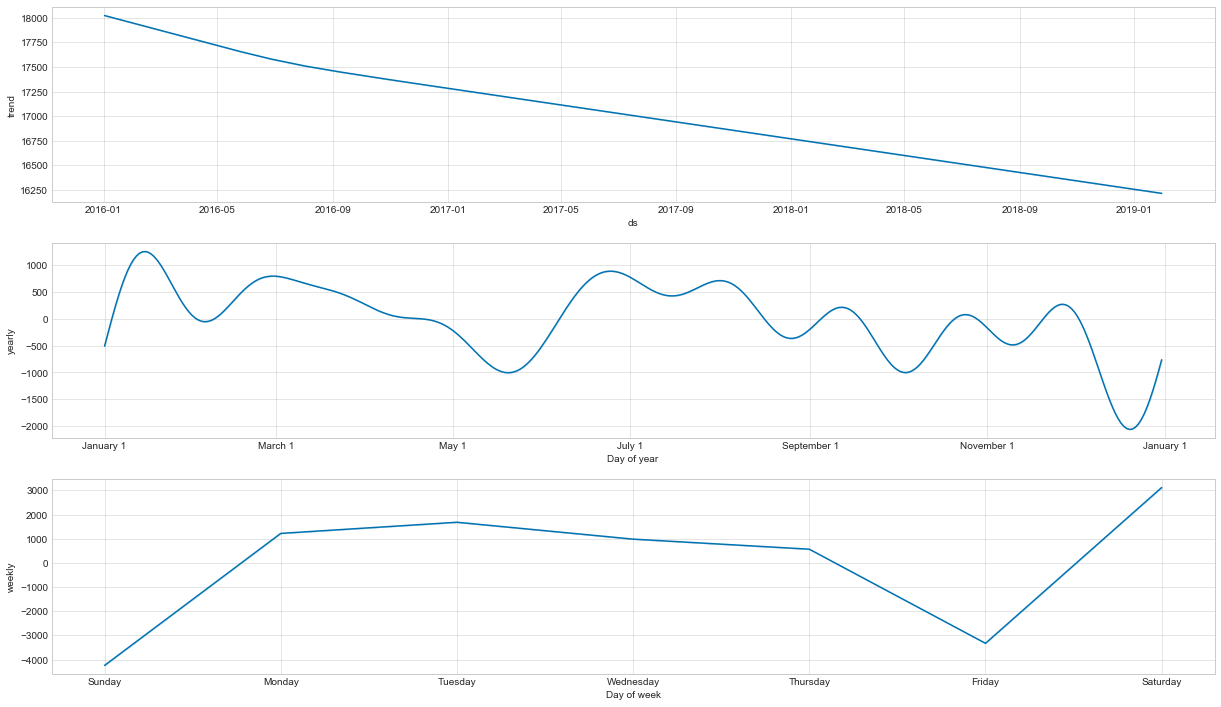

In [73]:
fig2 = m.plot_components(forecast)
fig2.set_size_inches(18, 10)
plt.show()

# Machine learning regression models for time series
Using a machine learning approach, we do some feature engineering and transform the data into an algorithm friendly tabular format. Then we will evaluate the models and do some error analysis.

In [75]:
# loading the three year timeseries

df = pd.read_csv('../../data/processed/checkout_counts_16to18.csv')
df['datetime'] = pd.to_datetime(df['datetime'], format= '%Y-%m-%d')
df.set_index('datetime', inplace=True)
df = df.resample('D').sum()
# create a date column to use to easily create features
df['date'] = df.index

## Feature Engineering
We create some calendar based features. Since some big swings usually happen after or before holidays, we create a feature to mark those days when something is likely to happen.

In [77]:
# create day, month, year columns
df['day'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

In [78]:
# create holiday column and add christmas eve to the list
holidays = holidays.UnitedStates()
holidays.append(['2016-12-24', '2017-12-24', '2018-12-24'])
df['holiday'] = df['date']
df['holiday'] = df['holiday'].apply(lambda x:1 if x in holidays else 0)
# create day after holiday column
df['after_holiday'] = df['holiday'].shift(1)
# create day before holiday column
df['before_holiday'] = df['holiday'].shift(-1)

In [79]:
# shift for 7 days
for i in range(1, 8):
    df['shift_'+str(i)] = df['checkouts'].shift(i)

In [80]:
df.head(16)

,checkouts,date,day,month,year,holiday,after_holiday,before_holiday,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7
datetime,,,,,,,,,,,,,,,
2016-01-02,24763,2016-01-02,5,1,2016,0,nan,0.00,nan,nan,nan,nan,nan,nan,nan
2016-01-03,14212,2016-01-03,6,1,2016,0,0.00,0.00,24763.00,nan,nan,nan,nan,nan,nan
2016-01-04,24704,2016-01-04,0,1,2016,0,0.00,0.00,14212.00,24763.00,nan,nan,nan,nan,nan
2016-01-05,21140,2016-01-05,1,1,2016,0,0.00,0.00,24704.00,14212.00,24763.00,nan,nan,nan,nan
2016-01-06,21135,2016-01-06,2,1,2016,0,0.00,0.00,21140.00,24704.00,14212.00,24763.00,nan,nan,nan
2016-01-07,21210,2016-01-07,3,1,2016,0,0.00,0.00,21135.00,21140.00,24704.00,14212.00,24763.00,nan,nan
2016-01-08,14540,2016-01-08,4,1,2016,0,0.00,0.00,21210.00,21135.00,21140.00,24704.00,14212.00,24763.00,nan
2016-01-09,26861,2016-01-09,5,1,2016,0,0.00,0.00,14540.00,21210.00,21135.00,21140.00,24704.00,14212.00,24763.00
2016-01-10,14955,2016-01-10,6,1,2016,0,0.00,0.00,26861.00,14540.00,21210.00,21135.00,21140.00,24704.00,14212.00


In [82]:
df[df.isnull().any(axis=1)]

,checkouts,date,day,month,year,holiday,after_holiday,before_holiday,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7
datetime,,,,,,,,,,,,,,,
2016-01-02,24763,2016-01-02,5,1,2016,0,nan,0.00,nan,nan,nan,nan,nan,nan,nan
2016-01-03,14212,2016-01-03,6,1,2016,0,0.00,0.00,24763.00,nan,nan,nan,nan,nan,nan
2016-01-04,24704,2016-01-04,0,1,2016,0,0.00,0.00,14212.00,24763.00,nan,nan,nan,nan,nan
2016-01-05,21140,2016-01-05,1,1,2016,0,0.00,0.00,24704.00,14212.00,24763.00,nan,nan,nan,nan
2016-01-06,21135,2016-01-06,2,1,2016,0,0.00,0.00,21140.00,24704.00,14212.00,24763.00,nan,nan,nan
2016-01-07,21210,2016-01-07,3,1,2016,0,0.00,0.00,21135.00,21140.00,24704.00,14212.00,24763.00,nan,nan
2016-01-08,14540,2016-01-08,4,1,2016,0,0.00,0.00,21210.00,21135.00,21140.00,24704.00,14212.00,24763.00,nan
2018-12-31,17292,2018-12-31,0,12,2018,0,0.00,nan,12960.00,18014.00,13348.00,17551.00,20534.00,0.00,0.00


#### Drop NA rows from the created shift feature

In [83]:
len(df[df.isnull().any(axis=1)])

8

In [84]:
df.dropna(inplace=True)

In [85]:
len(df[df.isnull().any(axis=1)])

0

### Define the models and evaluation methods

In [ ]:
def model_training(model, X_train, y_train, X_test):
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    return(y_pred)

def model_evaluation(title, model, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(title)
    print('MAE', round(mae, 2))
    print('RMSE', round(rmse, 2))
    importance = []
    if hasattr(model, 'feature_importances_'):
        print('Feature Importance')
        importance = []
        for i in range(len(X_columns)):
            importance.append([X_columns[i], model.feature_importances_[i]])
        print(pd.DataFrame(importance).sort_values(by=1, ascending=False).head(50))
    return(mae, rmse)

def run_experiment(title, model, X_train, y_train, X_test, y_test):
    y_pred = model_training(model, X_train, y_train, X_test)
    mae, rmse = model_evaluation(title, model, y_test, y_pred)
    plt.figure(figsize=(18,6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.show()
    plt.figure(figsize=(18,6))
    plt.plot(y_test.index, y_test)
    plt.plot(y_test.index, y_pred)
    plt.show()
    return(mae, rmse)

models = [
    ('LinearRegression', LinearRegression()),
    ('RandomForestRegressor50', RandomForestRegressor(n_estimators=50)),
    #('RandomForestRegressor100', RandomForestRegressor(n_estimators=100)),
    ('KNeighborsRegressor', KNeighborsRegressor())
]

In [86]:
df.columns

Index(['checkouts', 'date', 'day', 'month', 'year', 'holiday', 'after_holiday',
       'before_holiday', 'shift_1', 'shift_2', 'shift_3', 'shift_4', 'shift_5',
       'shift_6', 'shift_7'],
      dtype='object')

### Regression using only the day shifts
This model is not very good as the Mean absolute error of the best model (random forest) is 1856.34	and the RMSE is 3587.05. It doesn't capture the outliers at all.

In [99]:
# just shifts
X_columns = ['shift_1', 'shift_2', 'shift_3', 'shift_4', 'shift_5',
       'shift_6', 'shift_7']
y_column = ['checkouts']

#### Split the data

In [100]:
# Split the data. Do not shuffle

threshold = 0.9
absolute_threshold = int(len(df)*threshold)
print(len(df), absolute_threshold)

X_train = df.iloc[:absolute_threshold][X_columns]
y_train = df.iloc[:absolute_threshold][y_column]

X_test = df.iloc[absolute_threshold:][X_columns]
y_test = df.iloc[absolute_threshold:][y_column]

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

1087 978
X_train (978, 7)
y_train (978, 1)
X_test (109, 7)
y_test (109, 1)


LinearRegression
MAE 2278.53
RMSE 3902.13


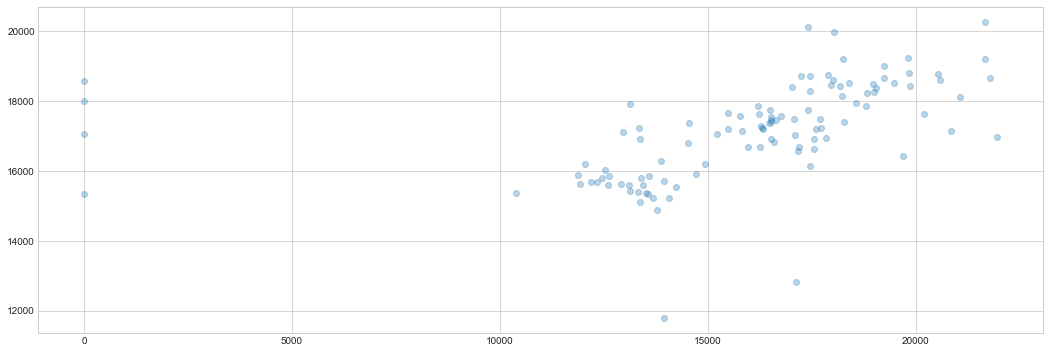

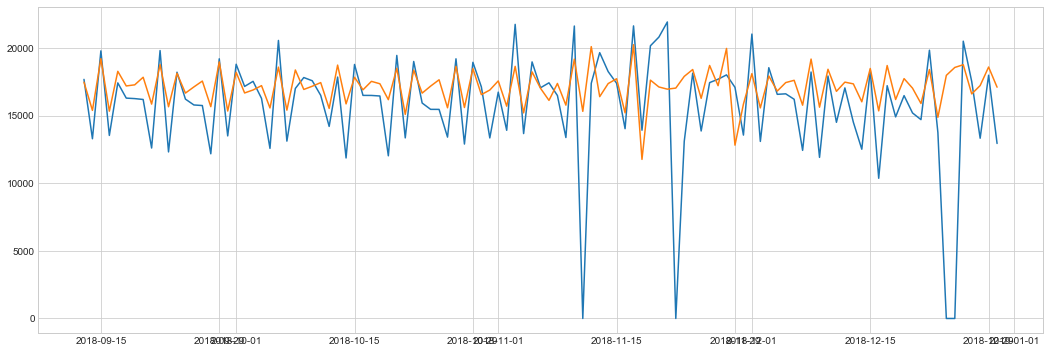

RandomForestRegressor50
MAE 1856.34
RMSE 3587.05
Feature Importance
         0    1
6  shift_7 0.39
0  shift_1 0.20
1  shift_2 0.11
2  shift_3 0.09
5  shift_6 0.08
4  shift_5 0.07
3  shift_4 0.06


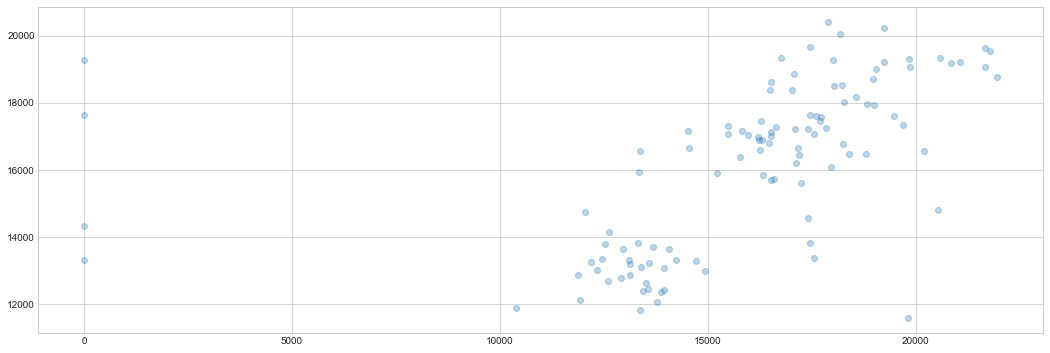

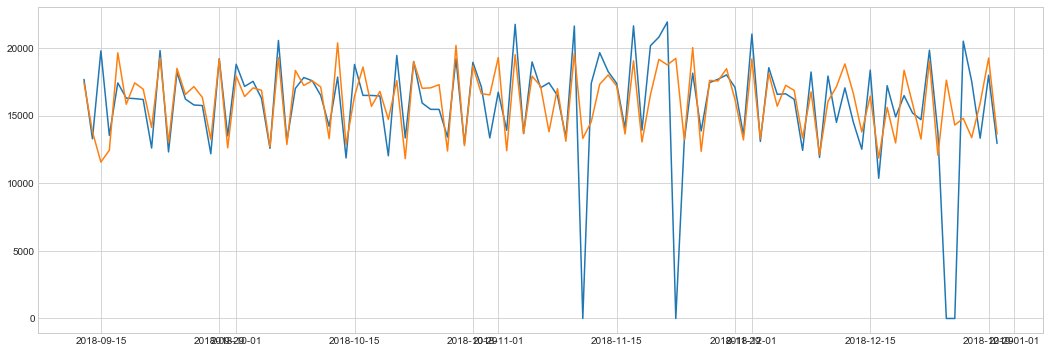

KNeighborsRegressor
MAE 1905.55
RMSE 3969.34


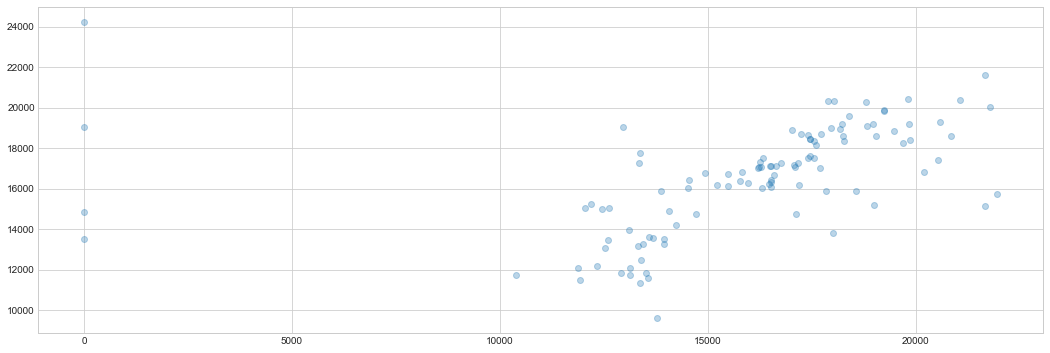

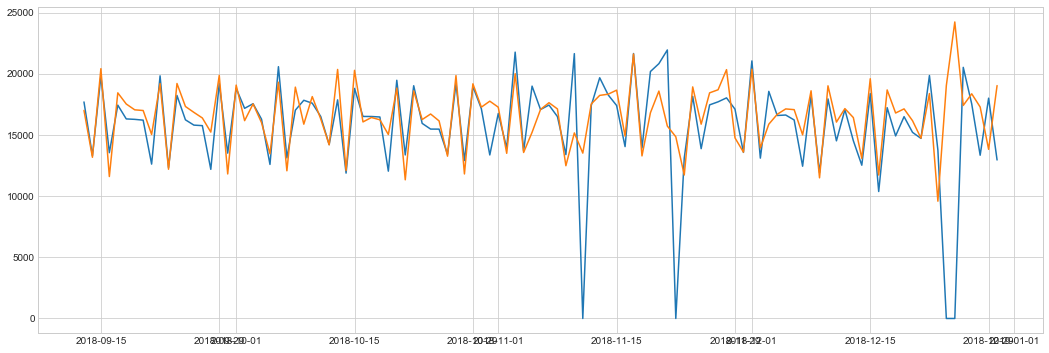

,model,mae,rmse
1,RandomForestRegressor50,1856.34,3587.05
2,KNeighborsRegressor,1905.55,3969.34
0,LinearRegression,2278.53,3902.13


In [101]:
# run the models
results = []
for m in models:
    mae, rmse = run_experiment(m[0], m[1], X_train, y_train, X_test, y_test)
    results.append([m[0], mae, rmse])
    
# sort the results and print as a table
df_results = pd.DataFrame(results)
df_results.columns = ['model', 'mae', 'rmse']
df_results = df_results.sort_values(by='mae')
df_results

### Add Calendar Features
Adding the calendar features greatly improved performance to a MAE of 1264.30 and RMSE of 1949.33 on the best model. The random forest model actually captured the holiday feature and, in fact, it abused it by creating a negative checkout value for one day. Note that the before and after holiday feature don't seem useful at all based on the feature importance metric.

1087 978
X_train (978, 13)
y_train (978, 1)
X_test (109, 13)
y_test (109, 1)
LinearRegression
MAE 1810.14
RMSE 2650.27


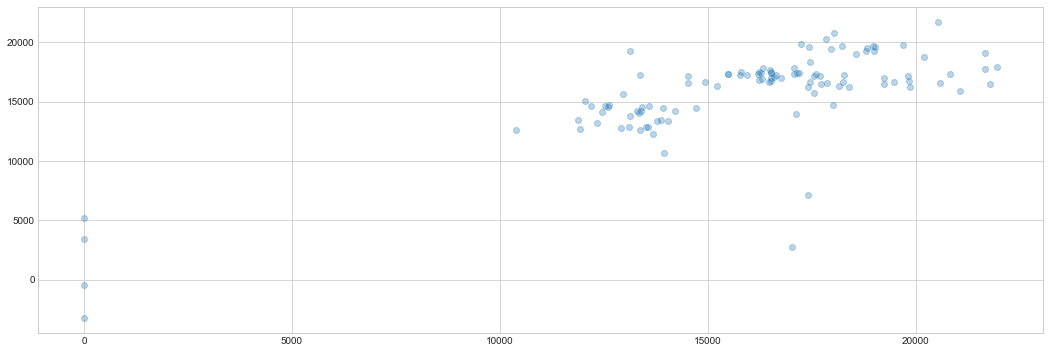

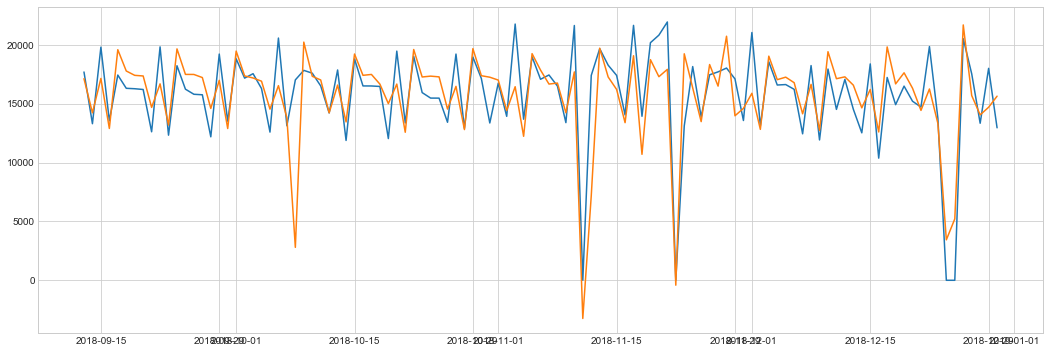

RandomForestRegressor50
MAE 1264.3
RMSE 1949.33
Feature Importance
                 0    1
6          shift_7 0.31
10         holiday 0.30
0          shift_1 0.13
7              day 0.06
1          shift_2 0.05
2          shift_3 0.04
5          shift_6 0.03
4          shift_5 0.03
3          shift_4 0.03
8            month 0.02
9             year 0.01
11   after_holiday 0.00
12  before_holiday 0.00


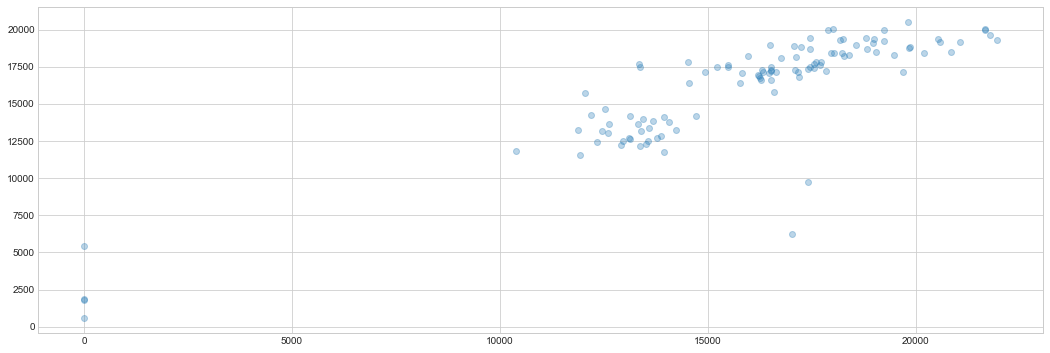

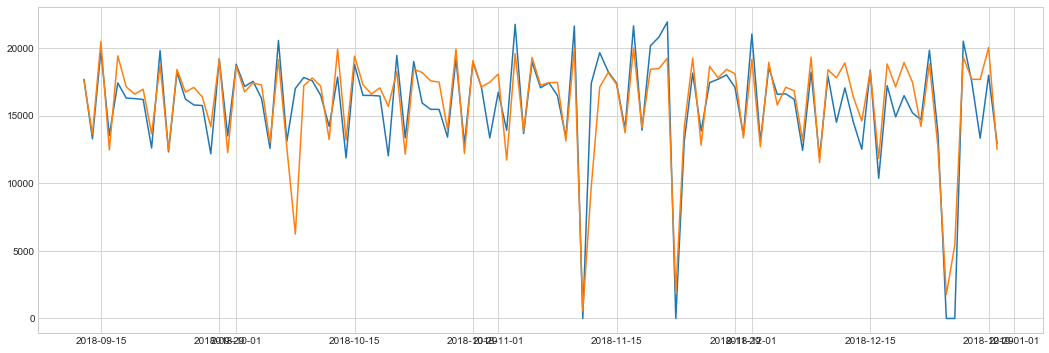

KNeighborsRegressor
MAE 1905.55
RMSE 3969.34


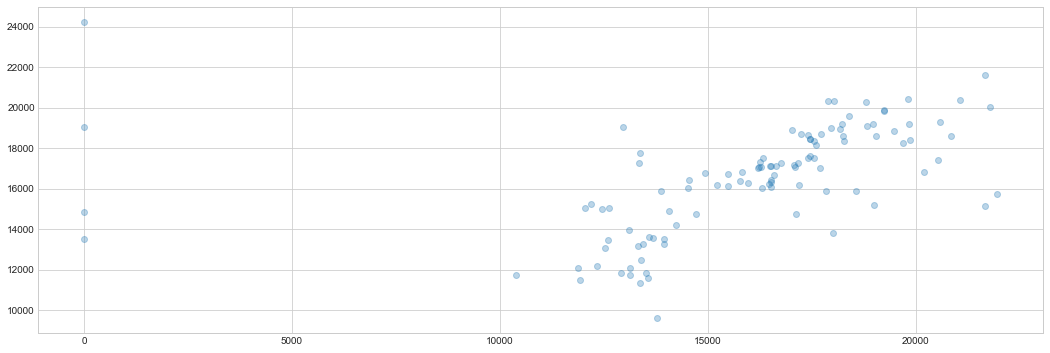

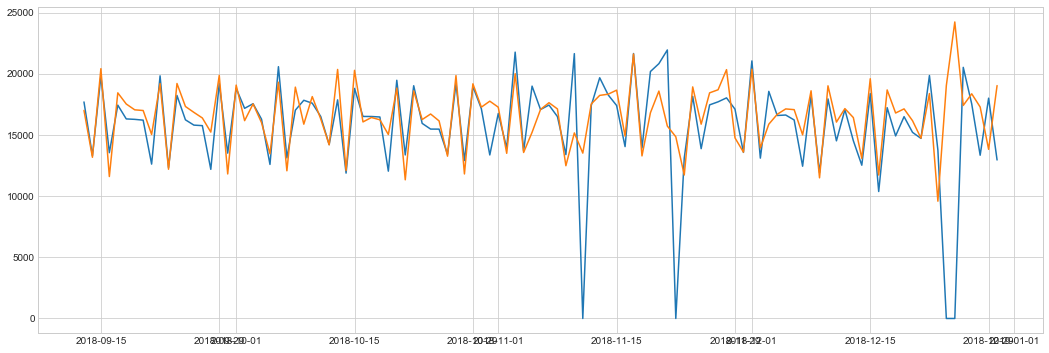

,model,mae,rmse
1,RandomForestRegressor50,1264.30,1949.33
0,LinearRegression,1810.14,2650.27
2,KNeighborsRegressor,1905.55,3969.34


In [104]:
# add time of year features
X_columns = ['shift_1', 'shift_2', 'shift_3', 'shift_4', 'shift_5',
       'shift_6', 'shift_7', 'day', 'month', 'year', 'holiday', 'after_holiday',
       'before_holiday']
y_column = ['checkouts']

# Split the data. Do not shuffle

threshold = 0.9
absolute_threshold = int(len(df)*threshold)
print(len(df), absolute_threshold)

X_train = df.iloc[:absolute_threshold][X_columns]
y_train = df.iloc[:absolute_threshold][y_column]

X_test = df.iloc[absolute_threshold:][X_columns]
y_test = df.iloc[absolute_threshold:][y_column]

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

# run the models
results = []
for m in models:
    mae, rmse = run_experiment(m[0], m[1], X_train, y_train, X_test, y_test)
    results.append([m[0], mae, rmse])
    
# sort the results and print as a table
df_results = pd.DataFrame(results)
df_results.columns = ['model', 'mae', 'rmse']
df_results = df_results.sort_values(by='mae')
df_results

### Remove day, before, and after holiday
This slightly improved the RMSE to 1900 but not significantly. The MAE was slightly worse. The extra columns might not be adding any necessary information and instead are maybe just adding noise.

1087 978
X_train (978, 10)
y_train (978, 1)
X_test (109, 10)
y_test (109, 1)
LinearRegression
MAE 1753.27
RMSE 2676.58


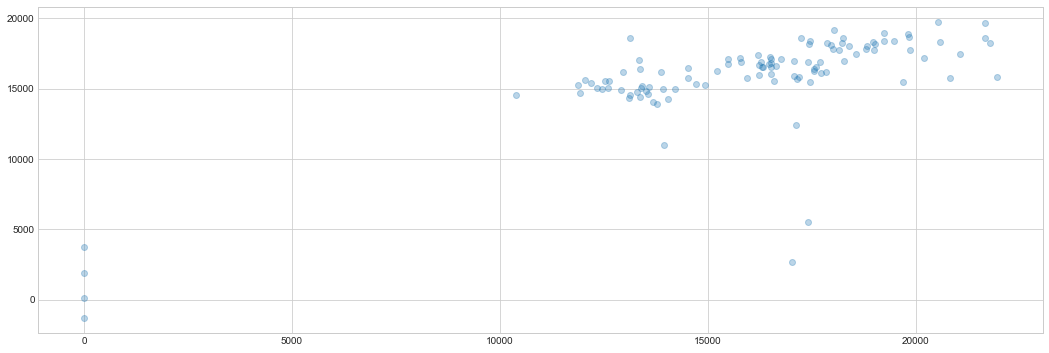

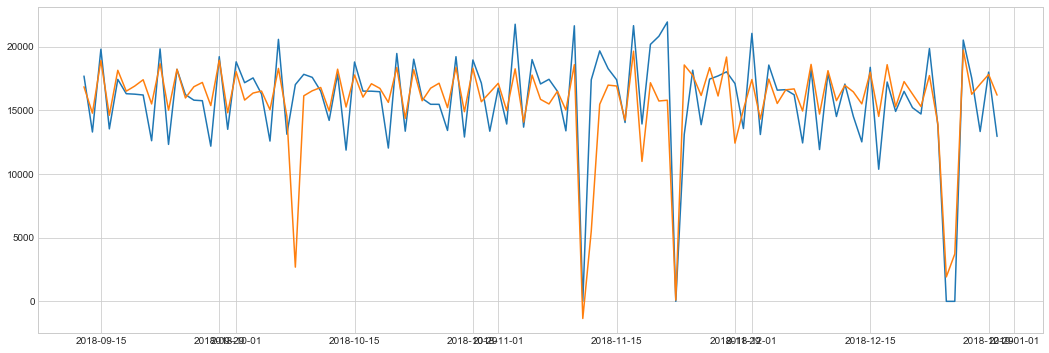

RandomForestRegressor50
MAE 1284.47
RMSE 1899.16
Feature Importance
         0    1
6  shift_7 0.35
9  holiday 0.30
0  shift_1 0.13
5  shift_6 0.05
1  shift_2 0.04
4  shift_5 0.04
2  shift_3 0.04
3  shift_4 0.03
7    month 0.02
8     year 0.01


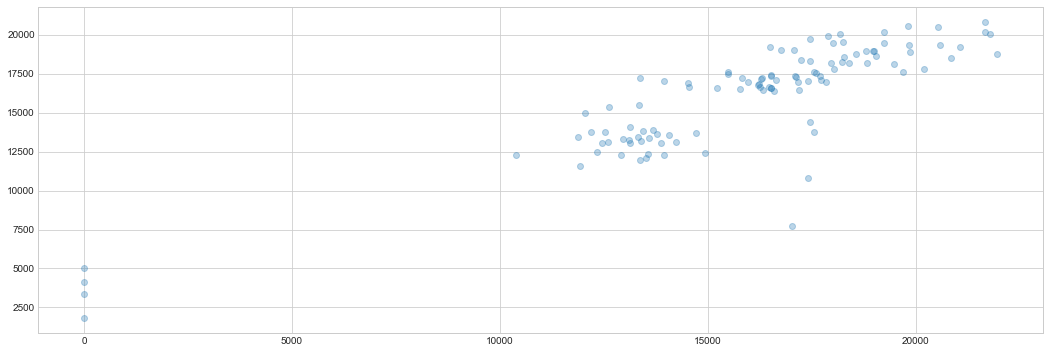

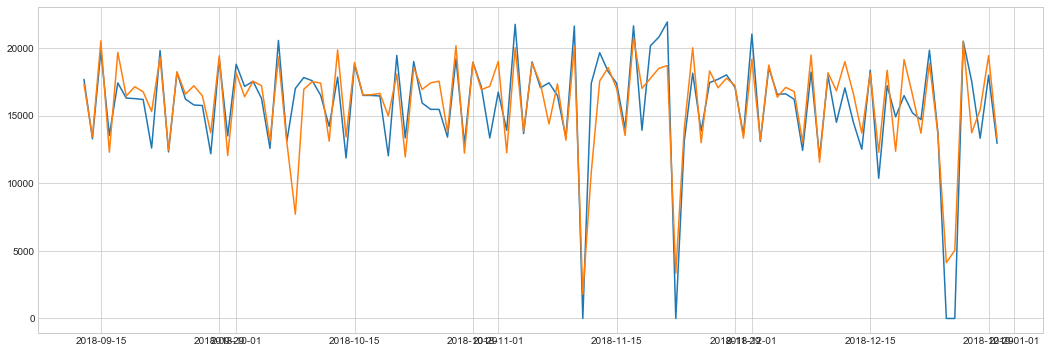

KNeighborsRegressor
MAE 1905.55
RMSE 3969.34


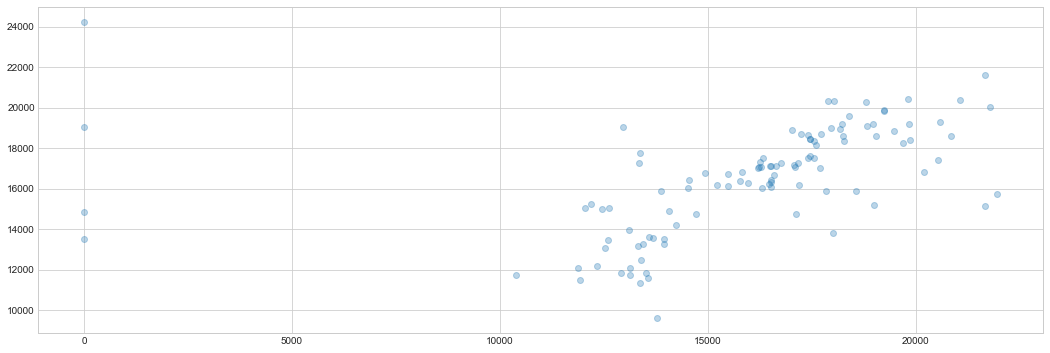

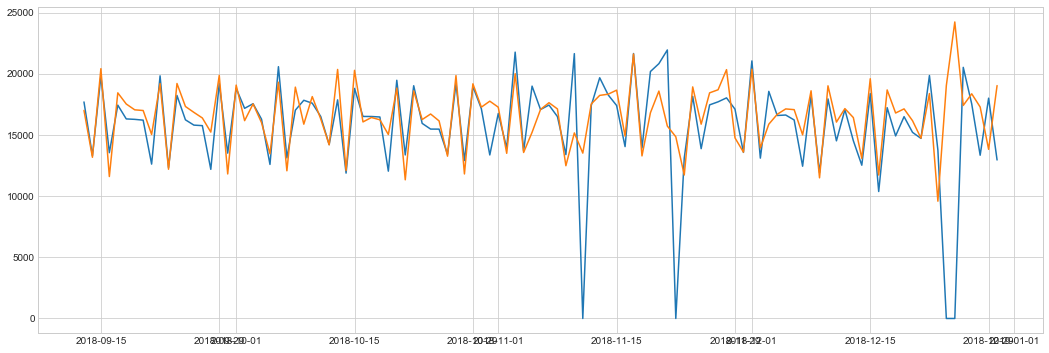

,model,mae,rmse
1,RandomForestRegressor50,1284.47,1899.16
0,LinearRegression,1753.27,2676.58
2,KNeighborsRegressor,1905.55,3969.34


In [106]:
# remove day because the shifts account for it already
X_columns = ['shift_1', 'shift_2', 'shift_3', 'shift_4', 'shift_5',
       'shift_6', 'shift_7', 'month', 'year', 'holiday']
y_column = ['checkouts']

# Split the data. Do not shuffle

threshold = 0.9
absolute_threshold = int(len(df)*threshold)
print(len(df), absolute_threshold)

X_train = df.iloc[:absolute_threshold][X_columns]
y_train = df.iloc[:absolute_threshold][y_column]

X_test = df.iloc[absolute_threshold:][X_columns]
y_test = df.iloc[absolute_threshold:][y_column]

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

# run the models
results = []
for m in models:
    mae, rmse = run_experiment(m[0], m[1], X_train, y_train, X_test, y_test)
    results.append([m[0], mae, rmse])
    
# sort the results and print as a table
df_results = pd.DataFrame(results)
df_results.columns = ['model', 'mae', 'rmse']
df_results = df_results.sort_values(by='mae')
df_results

### Removing outliers
Although we've run the model so far with significant outliers, we can see from the scatter plots that they have an important effect on the predictions. Removing them is the only way to see if improvements can be made.

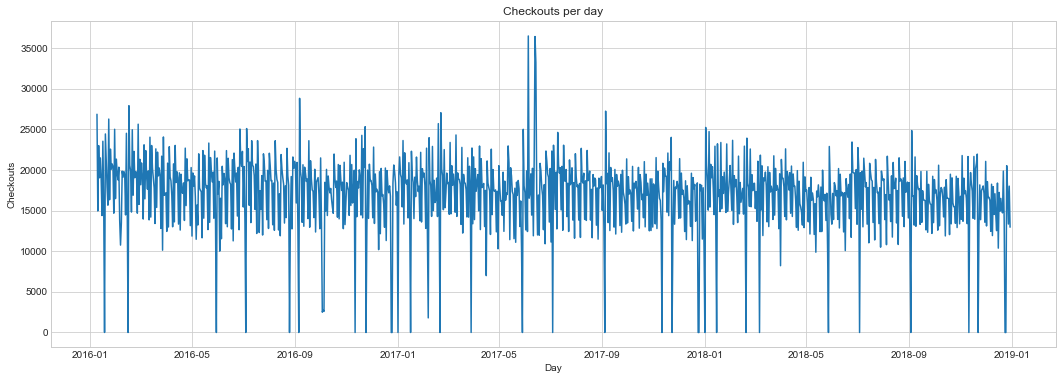

In [107]:
# plot daily chart
plt.figure(figsize=(18,6))
plt.plot(df['checkouts'])
plt.title('Checkouts per day')
plt.xlabel('Day')
plt.ylabel('Checkouts')
plt.show()

In [108]:
# remove values greater than 3 standard deviations
min_checkout = df['checkouts'].mean()-(3*df['checkouts'].std())
max_checkout = df['checkouts'].mean()+(3*df['checkouts'].std())
print(min_checkout, max_checkout)

3150.993350461147 30851.461111360382


In [109]:
df_outliers = df[(df['checkouts'] > min_checkout) & (df['checkouts'] < max_checkout)]

### Daily chart with closure outliers removed

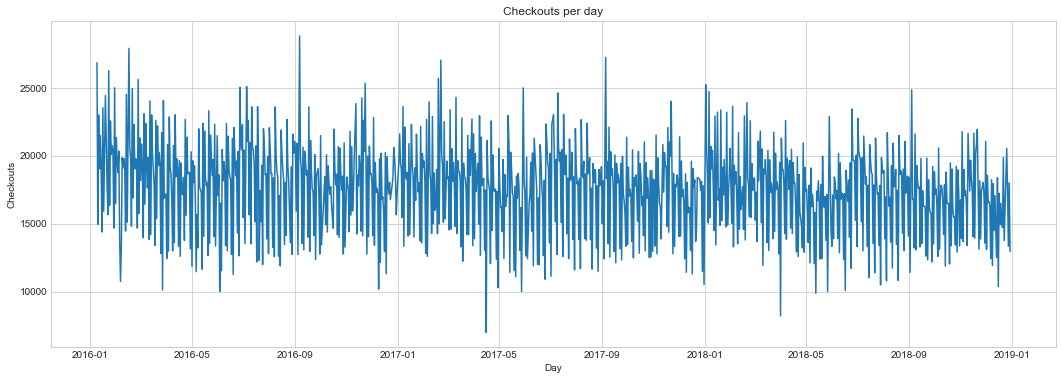

In [111]:
# plot daily chart
plt.figure(figsize=(18,6))
plt.plot(df_outliers['checkouts'])
plt.title('Checkouts per day')
plt.xlabel('Day')
plt.ylabel('Checkouts')
plt.show()

### Models with outliers removed
Both the MAE and RMSE have improved by removing the outliers. The random forest regressor still has the best RMSE with 1409, improving from almost 1900 before. The KNN model shows a significant improvement with an RMSE of 1611, down from 3969 before! The scatter plots look much better than the models with the outliers. A loose linear relationship can be see between the predictions and the actual values which is what we want. There shouldn't be much of a drawback in removing the outliers because it's not useful to know that the checkouts will be zero on days the library is closed. However, there should be a way to capture the spike before or after the closures. Unfortuneately, the before and after holiday features didn't seem to make a difference.

1048 943
X_train (943, 10)
y_train (943, 1)
X_test (105, 10)
y_test (105, 1)
LinearRegression
MAE 1608.94
RMSE 2034.97


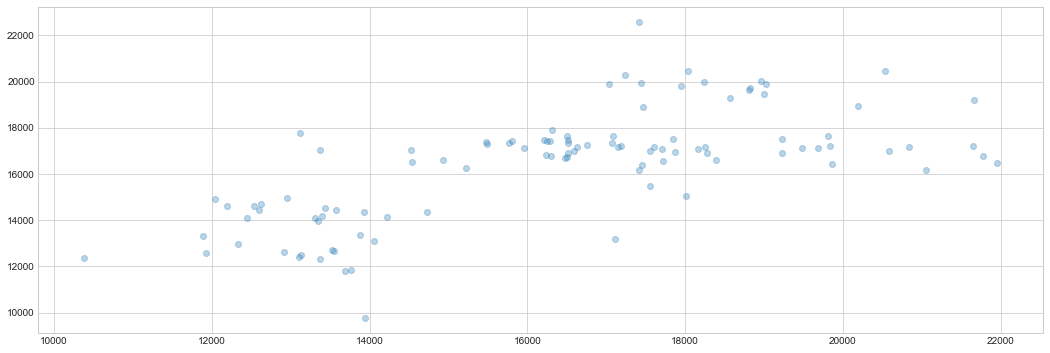

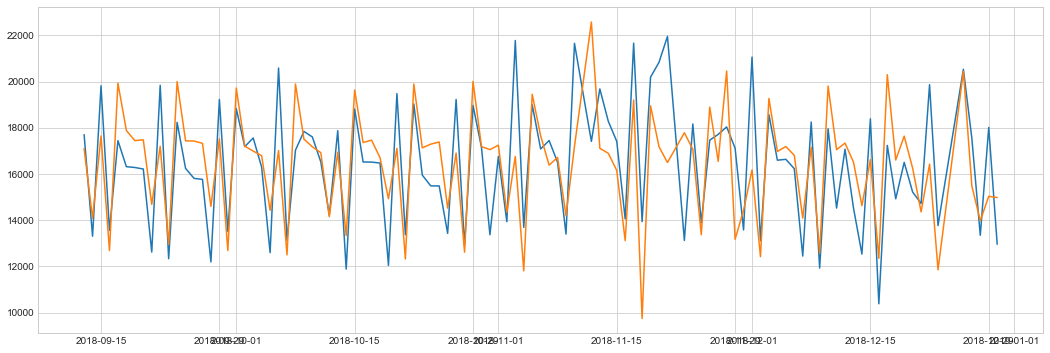

RandomForestRegressor50
MAE 1064.31
RMSE 1409.18
Feature Importance
         0    1
6  shift_7 0.57
0  shift_1 0.16
7      day 0.09
1  shift_2 0.04
2  shift_3 0.03
5  shift_6 0.03
3  shift_4 0.03
4  shift_5 0.03
8    month 0.03
9     year 0.01


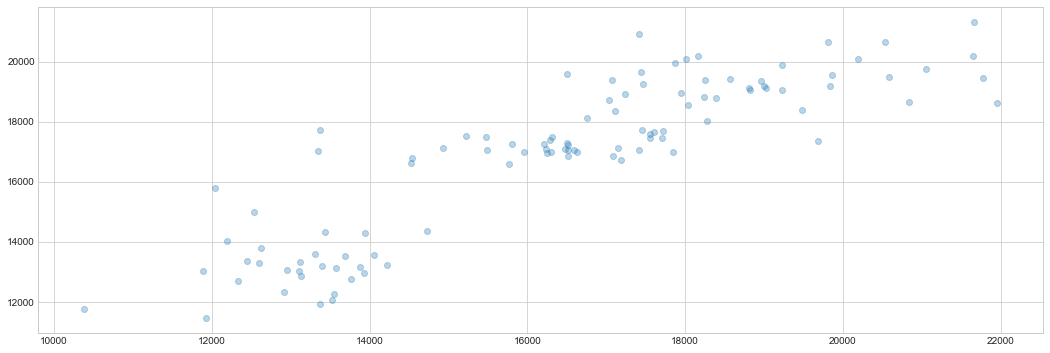

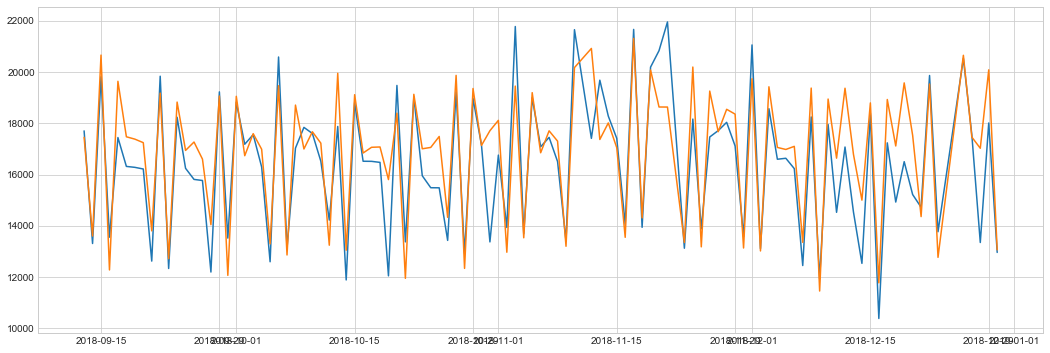

KNeighborsRegressor
MAE 1174.64
RMSE 1611.77


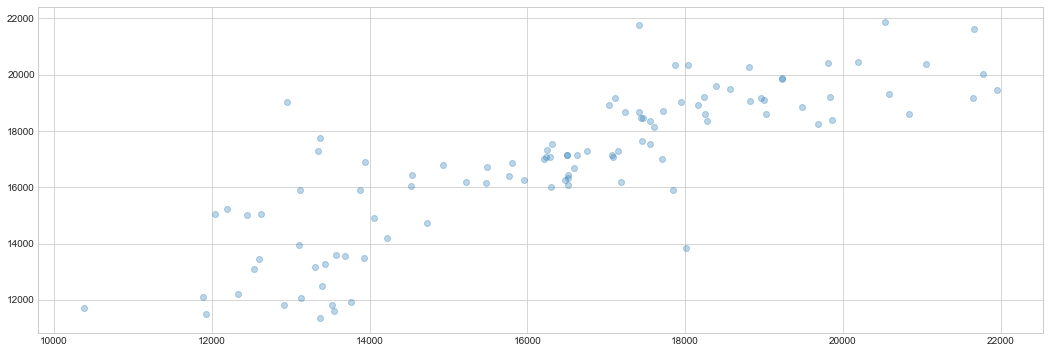

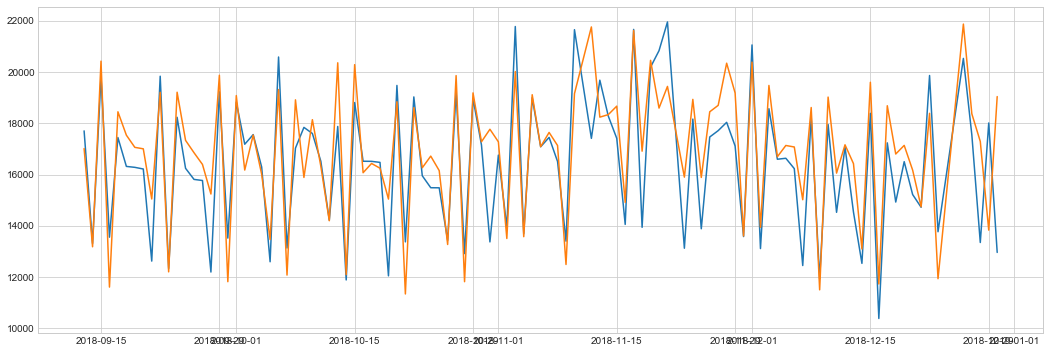

,model,mae,rmse
1,RandomForestRegressor50,1064.31,1409.18
2,KNeighborsRegressor,1174.64,1611.77
0,LinearRegression,1608.94,2034.97


In [149]:
X_columns = ['shift_1', 'shift_2', 'shift_3', 'shift_4', 'shift_5',
       'shift_6', 'shift_7', 'day', 'month', 'year']
y_column = ['checkouts']

# Split the data. Do not shuffle

threshold = 0.9
absolute_threshold = int(len(df_outliers)*threshold)
print(len(df_outliers), absolute_threshold)

X_train = df_outliers.iloc[:absolute_threshold][X_columns]
y_train = df_outliers.iloc[:absolute_threshold][y_column]

X_test = df_outliers.iloc[absolute_threshold:][X_columns]
y_test = df_outliers.iloc[absolute_threshold:][y_column]

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

results = []
for m in models:
    mae, rmse = run_experiment(m[0], m[1], X_train, y_train, X_test, y_test)
    results.append([m[0], mae, rmse])
    
# sort the results and print as a table
df_results = pd.DataFrame(results)
df_results.columns = ['model', 'mae', 'rmse']
df_results = df_results.sort_values(by='mae')
df_results

In [150]:
#Run the best model again for export
X_columns = ['shift_1', 'shift_2', 'shift_3', 'shift_4', 'shift_5',
       'shift_6', 'shift_7', 'day', 'month', 'year']
y_column = ['checkouts']

# Split the data. Do not shuffle

threshold = 0.9
absolute_threshold = int(len(df_outliers)*threshold)
print(len(df_outliers), absolute_threshold)

X_train = df_outliers.iloc[:absolute_threshold][X_columns]
y_train = df_outliers.iloc[:absolute_threshold][y_column]

X_test = df_outliers.iloc[absolute_threshold:][X_columns]
y_test = df_outliers.iloc[absolute_threshold:][y_column]

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

model = RandomForestRegressor(n_estimators=50)
model.fit(X_train, y_train.values.ravel())
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('MAE', mean_absolute_error(y_test, y_pred))
print('RMSE', round(rmse, 2))

1048 943
X_train (943, 10)
y_train (943, 1)
X_test (105, 10)
y_test (105, 1)
MAE 1075.077142857143
RMSE 1446.37


## Error Analysis
After removing the outliers, the errors improved but error analysis doesn't quite clearly explain what the source of the remaining error is. While the expected error from holidays around thanksgiving and veterans day is present, the rest of the errors don't have an obvious pattern. The only noticeably thing might be that December creates the most non-holiday related errors and they all seem to be underestimating the true checkout value.

In [151]:
df_test = pd.DataFrame(X_test)
df_test.columns = X_columns
df_test['checkouts'] = y_test
df_test['prediction'] = y_pred
df_test['error'] = abs(df_test['checkouts']-df_test['prediction'])
df_test.sort_values(by='error', ascending=False).round().head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,day,month,year,checkouts,prediction,error
datetime,,,,,,,,,,,,,
2018-10-19,16475.00,16516.00,16520.00,18811.00,11886.00,17877.00,14222.00,4,10,2018,12046,17123.00,5077.00
2018-10-31,17155.00,18969.00,12916.00,19228.00,13430.00,15483.00,15486.00,2,10,2018,13371,18103.00,4732.00
2018-12-28,17551.00,20534.00,0.00,0.00,13768.00,19867.00,14724.00,4,12,2018,13348,17296.00,3948.00
2018-11-12,0.00,21656.00,13400.00,16509.00,17451.00,17085.00,18999.00,0,11,2018,17413,20654.00,3241.00
2018-12-19,14927.00,17238.00,10382.00,18390.00,12533.00,14536.00,17075.00,2,12,2018,16503,19604.00,3101.00


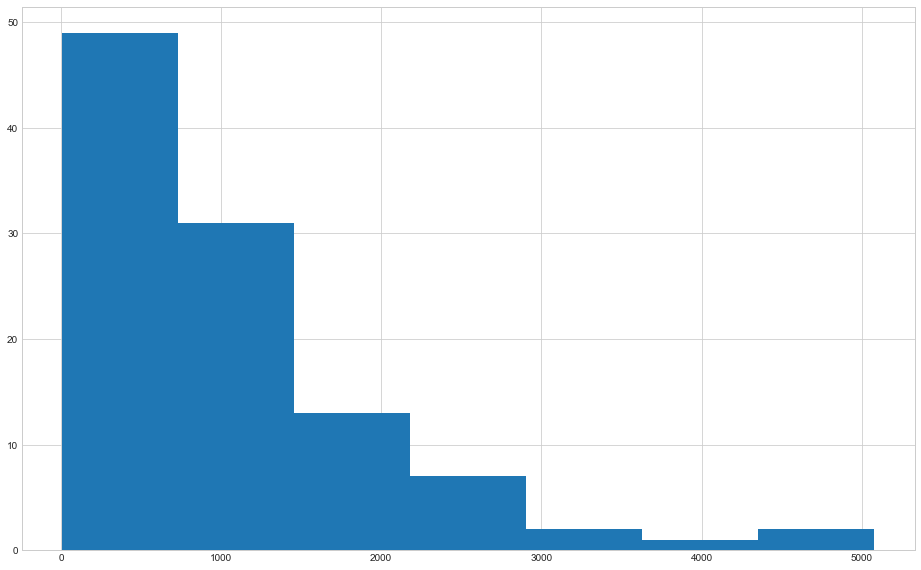

In [152]:
plt.hist(df_test['error'], bins=7)
plt.show()

In [153]:
# find the biggest errors
df_test[df_test['error']>2000]

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,day,month,year,checkouts,prediction,error
datetime,,,,,,,,,,,,,
2018-09-17,13555.00,19817.00,13309.00,17705.00,17597.00,18142.00,19296.00,0,9,2018,17445,19497.96,2052.96
2018-10-13,14222.00,16521.00,17604.00,17842.00,17033.00,13133.00,20589.00,5,10,2018,17877,20466.56,2589.56
2018-10-19,16475.00,16516.00,16520.00,18811.00,11886.00,17877.00,14222.00,4,10,2018,12046,17123.08,5077.08
2018-10-31,17155.00,18969.00,12916.00,19228.00,13430.00,15483.00,15486.00,2,10,2018,13371,18102.58,4731.58
2018-11-12,0.00,21656.00,13400.00,16509.00,17451.00,17085.00,18999.00,0,11,2018,17413,20654.44,3241.44
2018-11-13,17413.00,0.00,21656.00,13400.00,16509.00,17451.00,17085.00,1,11,2018,19684,17065.32,2618.68
2018-11-21,20836.00,20194.00,13940.00,21666.00,14054.00,17415.00,18283.00,2,11,2018,21957,19085.74,2871.26
2018-11-24,13124.00,0.00,21957.00,20836.00,20194.00,13940.00,21666.00,5,11,2018,18166,20302.22,2136.22
2018-11-26,13884.00,18166.00,13124.00,0.00,21957.00,20836.00,20194.00,0,11,2018,17467,19869.96,2402.96


In [154]:
df_test.corr()['error'].sort_values()

shift_4      -0.17
shift_1      -0.10
checkouts    -0.10
shift_3      -0.10
day          -0.03
shift_5      -0.02
shift_7       0.02
shift_2       0.03
shift_6       0.06
month         0.14
prediction    0.21
error         1.00
year           nan
Name: error, dtype: float64

In [158]:
#Run the best model again for export
X_columns = ['shift_1', 'shift_2', 'shift_3', 'shift_4', 'shift_5',
       'shift_6', 'shift_7', 'day', 'month', 'year']
y_column = ['checkouts']

# Split the data. Do not shuffle

threshold = 0.9
absolute_threshold = int(len(df_outliers)*threshold)
print(len(df_outliers), absolute_threshold)

X_train = df_outliers.iloc[:absolute_threshold][X_columns]
y_train = df_outliers.iloc[:absolute_threshold][y_column]

X_test = df_outliers.iloc[absolute_threshold:][X_columns]
y_test = df_outliers.iloc[absolute_threshold:][y_column]

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

model = RandomForestRegressor(n_estimators=50)
model.fit(X_train, y_train.values.ravel())
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('MAE', mean_absolute_error(y_test, y_pred))
print('RMSE', round(rmse, 2))

1048 943
X_train (943, 10)
y_train (943, 1)
X_test (105, 10)
y_test (105, 1)
MAE 1090.3131428571428
RMSE 1473.96


## Export the model to a pickle file

In [159]:
# save the model to file
filename = 'daily_checkout_model.pkl'
pickle.dump(model, open(filename, 'wb'))
 
# load the model from file
loaded_model = pickle.load(open(filename, 'rb'))

In [166]:
# make a prediction for checkouts in a day for a day in March given the necessary inputs
result = loaded_model.predict([[13555,19817,13309,17705,17597,18142,19296,3,3,2019]])
print(result)

[19771.24]
